In [2]:
import warnings
import pandas as pd
import numpy as np
import os
import operator # sorting
from read_trace import *

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

### read two concurrent kernel trace

In [3]:
# ls all the trace files in the targeted folder: two streams
target_folder = './profile_results'
trace_list = []
for root, dirs, files in os.walk(target_folder):
    for file in files:
        if 'trace' in file:
            trace_list.append(file)
            
            
# record the overlapping rate for different data size
ovlp_dict = {}

for item in trace_list:
    trace_file = target_folder + "/" + item
    current_ovlp = check_kernel_ovlprate(trace_file)
    # find out the data size
    N = item.replace("trace_", "").replace(".csv","")
    ovlp_dict[N] = current_ovlp
    
# sort the dd : the results is a list of tuple
sorted_ovlp_dict = sorted(ovlp_dict.items(), key=operator.itemgetter(1), reverse=True)

In [4]:
sorted_ovlp_dict[0:3]

[('23000', 0.4910424068328853),
 ('13000', 0.4844818516560228),
 ('15000', 0.48133918770516604)]

In [5]:
sorted_ovlp_dict[-5:]

[('293000', 0.03779421720792984),
 ('12000', -0.20098877522286235),
 ('17000', -0.5134685199684521),
 ('21000', -0.5675193337274169),
 ('18000', -0.7712761471005442)]

In [6]:
max_ovlp = sorted_ovlp_dict[0][1]
max_ovlp = round(max_ovlp, 3) 
print max_ovlp

0.491


In [7]:
min_ovlp = 0

for i in range(1, len(sorted_ovlp_dict)):
    current_ovlp = sorted_ovlp_dict[-i][1]
    if current_ovlp > 0:
        min_ovlp = current_ovlp
        break
        
min_ovlp = round(min_ovlp, 3) 
print min_ovlp

0.038


### iterate through the ovlp dd, record the kernel slowdown ratio

In [8]:
data_size_ls = []
ovlp_rate_ls = []
slowdown_ls = []

for item in sorted_ovlp_dict:
    data_size = str(item[0])     # string
    ovlp_rate = float(item[1])
    
    if ovlp_rate > 0:
        # trace file for current data size
        s1_trace_file = 'profile_results_s1/trace_' + data_size + '.csv'
        s2_trace_file = 'profile_results/trace_' + data_size + '.csv'

        #print s1_trace_file
        #print s2_trace_file

        # find out single stream kernel runtime
        df_current = trace2dataframe(s1_trace_file)
        s1_kernel_dd = get_kernel_time_from_trace(df_current)

        # find out two stream kernel runtime
        df_current = trace2dataframe(s2_trace_file)
        s2_kernel_dd = get_kernel_time_from_trace(df_current)

        slow_down_ratio_list = kernel_slowdown(s1_kernel_dd, s2_kernel_dd)

        #print slow_down_ratio_list

        # update the list
        data_size_ls.append(data_size)
        ovlp_rate_ls.append(ovlp_rate)
        slowdown_ls.append(slow_down_ratio_list)

In [9]:
data_size_ls[:3]

['23000', '13000', '15000']

In [10]:
ovlp_rate_ls[0:3]

[0.4910424068328853, 0.4844818516560228, 0.48133918770516604]

In [11]:
slowdown_ls[0:3]

[[1.0833497117400006, 1.2945492662466183],
 [1.6192504258960279, 1.1456558773440018],
 [1.3173961181282048, 1.044806471292562]]

### plot figure : kernel slown  vs overlapping_rate

In [12]:
print len(ovlp_rate_ls)

285


In [13]:
s1_kernel_slowndown = []
s2_kernel_slowndown = []

for item in slowdown_ls:
    s1_kernel_slowndown.append(item[0])
    s2_kernel_slowndown.append(item[1])

In [14]:
print s1_kernel_slowndown[0]
print s2_kernel_slowndown[0]

1.08334971174
1.29454926625


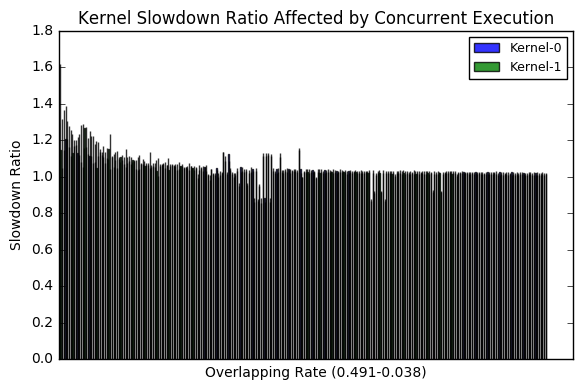

In [15]:
n_groups = len(ovlp_rate_ls)
#s1_kernel_slowndown
#s2_kernel_slowndown

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.05
opacity = 0.8

# kernel 1
rects1 = plt.bar(index, s1_kernel_slowndown, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Kernel-0')
 
# kernel 2
rects2 = plt.bar(index + bar_width, s2_kernel_slowndown, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Kernel-1')

# annotate the overlapping range
xlabel_note = 'Overlapping Rate (' + str(max_ovlp) + '-' + str(min_ovlp) + ')' 
plt.xlabel(xlabel_note)

plt.ylabel('Slowdown Ratio')
plt.title('Kernel Slowdown Ratio Affected by Concurrent Execution')

#plt.xticks(index + bar_width, ovlp_rate_ls)
# turn off the ticks
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off


plt.legend(prop={'size':9})


plt.tight_layout()
plt.show()

### pick 10 points among the list

In [19]:
ovlp_rate_ls[0:5]

[0.4910424068328853,
 0.4844818516560228,
 0.48133918770516604,
 0.480318791226974,
 0.4784069018877757]

In [18]:
slowdown_ls[0:5]

[[1.0833497117400006, 1.2945492662466183],
 [1.6192504258960279, 1.1456558773440018],
 [1.3173961181282048, 1.044806471292562],
 [1.1440708486109004, 1.367224332110451],
 [1.2066314367450417, 1.3884496185626074]]

In [24]:
print max_ovlp
print min_ovlp

0.491
0.038


In [20]:
from math import *

def find_10_pos(N):
    step_size = N / 10.
    pos_list = []
    current_pos = 0
    for i in xrange(10):
        current_pos = floor(current_pos + step_size)
        pos_list.append(current_pos)
    return pos_list

def find_5_pos(N):
    step_size = N / 5.
    pos_list = []
    current_pos = 0
    for i in xrange(5):
        current_pos = floor(current_pos + step_size)
        pos_list.append(current_pos)
    return pos_list


In [22]:
def find_closet_value_pos(ovlp_rate_ls, value):
    """
    Iterate through the list to find the position of the value
    """
    pos = 0
    min_diff = fabs(value - ovlp_rate_ls[0]) 
    
    for i in xrange(1, len(ovlp_rate_ls)):
        cur_diff = fabs(value - ovlp_rate_ls[i])
        if cur_diff < min_diff:
            min_diff = cur_diff
            pos = i
    return pos

def find_10_pos_by_range(max_val, min_val, ovlp_rate_ls):
    """
    Go downwards from the ovlp_rate_ls, look for indices of 10 data points to plot.
    """
    step_size = (max_val - min_val) * 0.1
    
    pos_list = [0] # the 1st in the list
    current_value = ovlp_rate_ls[0]
    
    # there are 9 left
    for i in xrange(9):
        current_value = current_value - step_size
        # find the nearest value index
        current_value_ind = find_closet_value_pos(ovlp_rate_ls, current_value)
        # update to the pos list
        pos_list.append(current_value_ind)
        
    return pos_list

def find_5_pos_by_range(max_val, min_val, ovlp_rate_ls):
    """
    Go downwards from the ovlp_rate_ls, look for indices of 10 data points to plot.
    """
    step_size = (max_val - min_val) * 0.2
    
    pos_list = [0] # the 1st in the list
    current_value = ovlp_rate_ls[0]
    
    # there are 4 left
    for i in xrange(4):
        current_value = current_value - step_size
        # find the nearest value index
        current_value_ind = find_closet_value_pos(ovlp_rate_ls, current_value)
        # update to the pos list
        pos_list.append(current_value_ind)
        
    return pos_list


In [26]:
total_samples = len(ovlp_rate_ls)

target_pos = None

if total_samples > 10:
    target_pos = find_10_pos_by_range(max_ovlp, min_ovlp, ovlp_rate_ls)
    
elif total_samples > 5:
    target_pos = find_5_pos_by_range(max_ovlp, min_ovlp, ovlp_rate_ls)
else:
    print("Not engough data!")

In [28]:
# print target_pos
target_pos

[0, 5, 7, 8, 19, 20, 31, 42, 69, 119]

In [30]:
ovlp_rate_ls_2plot = []

s1_kernel_slowndown_2plot = []
s2_kernel_slowndown_2plot = []

for item in target_pos:
    pos = int(item)
    current_ovlp = ovlp_rate_ls[pos]
    s1_sd = s1_kernel_slowndown[pos]
    s2_sd = s2_kernel_slowndown[pos]
    
    # add to plot list
    ovlp_rate_ls_2plot.append(current_ovlp)
    s1_kernel_slowndown_2plot.append(s1_sd)
    s2_kernel_slowndown_2plot.append(s2_sd)
    
# print ovlp_rate_ls_2plot

# round to 3 decimal
ovlp_rate_ls_2plot_rnd = [round(x, 3) for x in ovlp_rate_ls_2plot]
print ovlp_rate_ls_2plot_rnd

[0.491, 0.442, 0.413, 0.353, 0.32, 0.267, 0.232, 0.174, 0.128, 0.083]


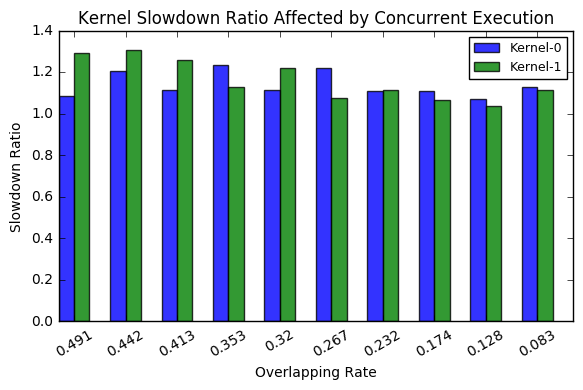

In [32]:
n_groups = len(ovlp_rate_ls_2plot_rnd)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.8

# kernel 1
rects1 = plt.bar(index, s1_kernel_slowndown_2plot, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Kernel-0')
 
# kernel 2
rects2 = plt.bar(index + bar_width, s2_kernel_slowndown_2plot, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Kernel-1')


plt.xlabel('Overlapping Rate')
plt.ylabel('Slowdown Ratio')
plt.title('Kernel Slowdown Ratio Affected by Concurrent Execution')

#plt.xticks(index + bar_width, ovlp_rate_ls_2plot)
plt.xticks(index + bar_width, ovlp_rate_ls_2plot_rnd, rotation=30)

plt.legend(prop={'size':9})
 
plt.tight_layout()
plt.show()